In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from math import sqrt
%matplotlib inline
sns.set(style="darkgrid")
import warnings
warnings.filterwarnings('ignore')

### 1. Классификация. Предсказание является ли письмо спамом или нет на основании ключевых слов.

In [2]:
data = pd.read_csv("emails.csv")

In [3]:
data.shape

(5172, 3002)

### 2. Препроцессинг данных

In [4]:
data.columns

Index(['Email No.', 'the', 'to', 'ect', 'and', 'for', 'of', 'a', 'you', 'hou',
       ...
       'connevey', 'jay', 'valued', 'lay', 'infrastructure', 'military',
       'allowing', 'ff', 'dry', 'Prediction'],
      dtype='object', length=3002)

In [5]:
del data['Email No.']

In [6]:
data.head()

,the,to,ect,and,for,of,a,you,hou,in,...,connevey,jay,valued,lay,infrastructure,military,allowing,ff,dry,Prediction
0,0,0,1,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,8,13,24,6,6,2,102,1,27,18,...,0,0,0,0,0,0,0,1,0,0
2,0,0,1,0,0,0,8,0,0,4,...,0,0,0,0,0,0,0,0,0,0
3,0,5,22,0,5,1,51,2,10,1,...,0,0,0,0,0,0,0,0,0,0
4,7,6,17,1,5,2,57,0,9,3,...,0,0,0,0,0,0,0,1,0,0


In [7]:
for i in data.columns[:-1]:
    idx = data.index[data[i] > data[i].std()*12]
    data.drop(idx, inplace=True)
data.shape

(707, 3001)

In [8]:
to_del = []
for i in data.columns[:-1]:
    if sum((data[i] == 0).to_numpy()) > data.shape[0]*0.9:
        to_del.append(i)
data = data.drop(columns=to_del)
data.shape

### 2*. Посмотрим на корреляцию данных.

In [9]:
# figure = plt.figure(figsize=(12,12))
# sns.heatmap(data.corr(), annot=True, cmap='coolwarm')

### 3. Реализация метрики качества. \\ аргументировать выбор метрики качества 

Так как у нас всего два класса, используем оценки качества precision и recall, но нам надо обьеденить их в одну, поэтому используем новое выражение называемое F-мерой, который считается как 
```(1 + betta**2) * (precision * recall) / ((betta**2 * precision) + recall)```

In [10]:
def F(x, y, betta=1):
    TP = sum([x[i] == 1 and y[i] == 1 for i in range(len(x))])
    FP = sum([x[i] == 1 and y[i] == 0 for i in range(len(x))])
    FN = sum([x[i] == 0 and y[i] == 1 for i in range(len(x))])
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    return (1 + betta**2) * (precision * recall) / ((betta**2 * precision) + recall)

### Разбиение на обучающую и тестовую выборки

In [11]:
indicators = data.columns[:-1]
target_columns = data.columns[-1]

In [12]:
X = data[indicators]
y = data[target_columns]

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X.to_numpy(), y, test_size=0.2)

In [14]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((565, 109), (142, 109), (565,), (142,))

### 4. Реализовать и обучить логистическую регрессию или линейную регрессию \\ !!!не разрешается использовать sklearn!!!

In [15]:
class LR:
    def __init__(self, step=10**-2, it_c=1000):
        self.step = step
        self.it_c = it_c

    def get_coeff(self, x, y):
        return self.err(x, y.values.ravel())
    
    def err(self, x, y):
        p = [self.predict(i) for i in x]
        return sum(p==y) / len(y)
    
    def reg(self):
        return 0
    
    def fit(self, x, y):
        y = y.to_numpy()
        np.c_[x, np.ones(len(x))]
        self.w = np.zeros(x.shape[1])
        f, h = [], []
        for i in range(self.it_c):
            z = [sum([x[i][j]*self.w[j] for j in range(len(x[i]))]) for i in range(len(x))]
            res = np.array([1 / (1 + np.exp(-a)) for a in z])
            grad = np.dot(x.T, res - y) / y.size
            self.w -= self.step * grad - self.reg()
            h.append(self.err(x, y))
            f.append(F(self.predict(x), y))
        return h, f
            
    def predict(self, x):
        np.append(x,1)
        return (1 / (1 + np.exp(-np.dot(x, self.w)))).round()
    
    def F_mera(self, x, y):
        f(x,y)

In [16]:
mlg = LR()
hist, f = mlg.fit(X_train, y_train)
print(f"\nmy LogReg: {mlg.get_coeff(X_test, y_test)}")


my LogReg: 0.971830985915493


### 4*. Добавить регуляризацию \\ не разрешается использовать sklearn

In [33]:
class LRreg(LR):
    def __init__(self, step=10**-2, it_c=1000, L=None, alpha=0.00001):
        self.step = step
        self.it_c = it_c
        self.L = L
        self.alpha = alpha
        
    def reg(self):
        if self.L == 'L1':
            return self.alpha * sum([abs(i) for i in self.w])
        elif self.L == 'L2':
            return self.alpha * sum([i**2 for i in self.w])
        else:
            return 0

### 5. Оценить качество модели на обучающей и тестовой выборках \\ не разрешается использовать sklearn

In [34]:
mlgL1 = LRreg(L='L1')
histL1, fL1 = mlgL1.fit(X_train, y_train)
print(f"\nmy LogReg L1: {mlgL1.get_coeff(X_test, y_test)}")


my LogReg L1: 0.971830985915493


In [35]:
mlgL2 = LRreg(L='L2')
histL2, fL2 = mlgL2.fit(X_train, y_train)
print(f"\nmy LogReg L2: {mlgL2.get_coeff(X_test, y_test)}")


my LogReg L2: 0.971830985915493


### 5*. Сделать график ошибки модели на обучающей и тестовой выборках 
### 5*. Сделать график точности модели на обучающей и тестовой выборках

#### График точности моделей для всех регулязациях (без нее, L1, L2)

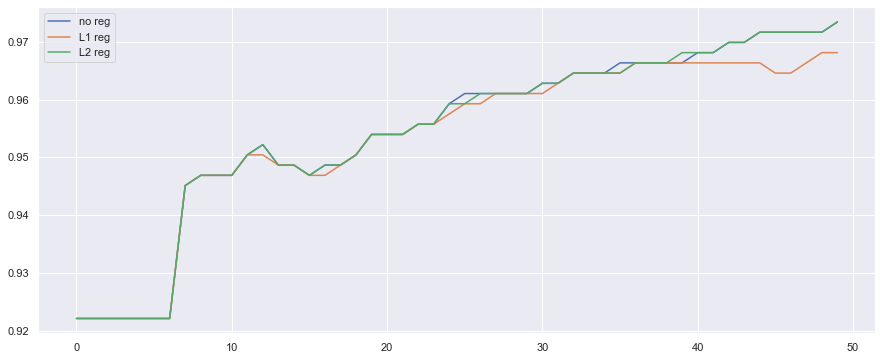

In [41]:
figure = plt.figure(figsize=(15,6))
plt.plot(hist[::20], label="no reg")
plt.plot(histL1[::20], label="L1 reg")
plt.plot(histL2[::20], label="L2 reg")
plt.legend()
plt.show()

#### График метрики моделей для всех регулязациях (без нее, L1, L2) чем больше тем лучше

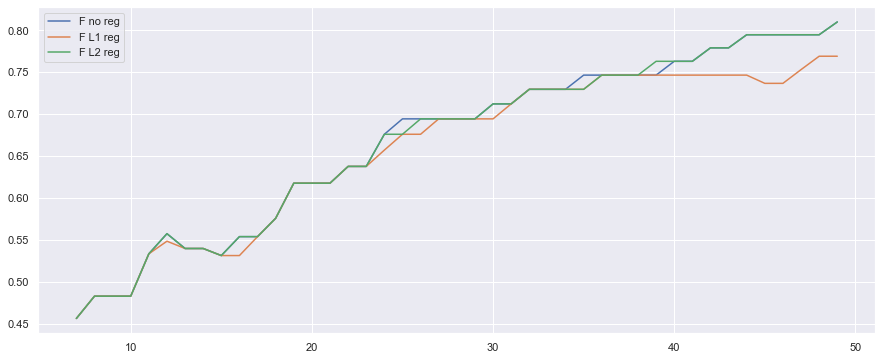

In [42]:
figure = plt.figure(figsize=(15,6))
plt.plot(f[::20], label="F no reg")
plt.plot(fL1[::20], label="F L1 reg")
plt.plot(fL2[::20], label="F L2 reg")
plt.legend()
plt.show()

### 6. Обучить логистическую регрессию или линейную регрессию из sklearn, оценить качество модели на обучающей и тестовой выборках и сравнить со своей моделью

In [38]:
from sklearn.linear_model import LogisticRegression
sklg = LogisticRegression(max_iter=1400)
sklg.fit(X_train, y_train.values.ravel())
print(f"sklearn: {sklg.score(X_test, y_test.values.ravel())}")

sklearn: 1.0


### 6*. Сделать график ошибки модели из sklearn на обучающей и тестовой выборках и сравнить со своей моделью
### 6*. Сделать график точности модели из sklearn на обучающей и тестовой выборках и сравнить со своей моделью

In [39]:
from sklearn.model_selection import learning_curve
train_sizes, train_scores, valid_scores = learning_curve(
    LogisticRegression(max_iter=1400), X_train, y_train.values.ravel(), cv=5)

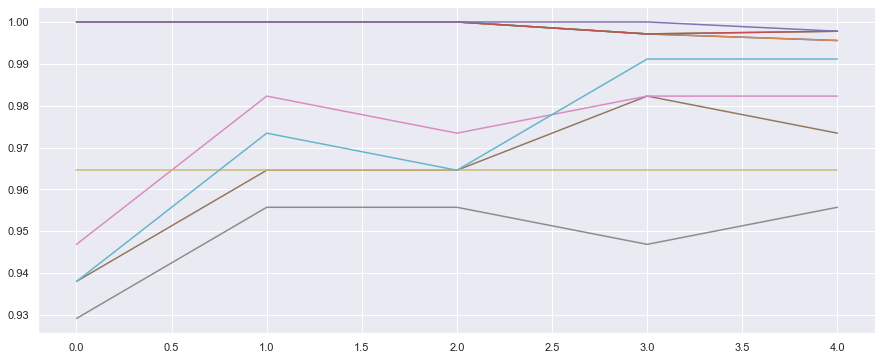

In [40]:
figure = plt.figure(figsize=(15,6))
plt.plot(train_scores)
plt.plot(valid_scores)
plt.show()